# Importing Libraries

In [83]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# Load Dataset

In [84]:
data = pd.read_csv('/content/drive/MyDrive/Platinum Challenge/train_preprocess.tsv.txt', sep='\t', header=None, names=['text', 'label'])

# Display data describe and data information

In [85]:
data.describe()

,text,label
count,11000,11000
unique,10933,3
top,kesal,positive
freq,4,6416


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


# Preprocess Data

Stopwords

In [87]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming

In [88]:
#from nltk.stem import PorterStemmer
#stemmer = PorterStemmer()

In [89]:
def preprocess_text(text):
    text = text.lower()                                 # Mengubah menjadi huruf kecil
    text = re.sub(r'\s+', ' ', text)                    # Mengganti banyak spasi dengan satu spasi
    text = re.sub(r'[^a-zA-Z\s]', '', text)             # Menghapus karakter spesial kecuali spasi
    text = re.sub(r'\t', ' ', text)                     # Menghapus tab dan menggantinya dengan spasi
    text = re.sub(r'\d+', '', text)                     # Menghapus angka
    text = re.sub(f"[{string.punctuation}]", "", text)  # Menghapus tanda baca
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Menghapus stopwords
    return text

In [90]:
data['cleaned_text'] = data['text'].apply(preprocess_text)
data.head()

,text,label,cleaned_text
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung dimiliki pengusaha pabrik puluhan terke...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus k mmbri hujjah partai diwlh ...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis jalan sumatera bandung nya ny...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya unboxing paket barang nya b...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh mahasiswa sombong kasih kartu kuning belaj...


In [91]:
print(len(data['label']))

11000


In [92]:
idx = 711
print (data['cleaned_text'][idx])

siapsiap turun gunung mendukung menangkan djarot gubernur sumatera utara


In [93]:
# Encode labels
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
data['label'] = data['label'].map(label_map).values
data['cleaned_text'].head()

0    warung dimiliki pengusaha pabrik puluhan terke...
1    mohon ulama lurus k mmbri hujjah partai diwlh ...
2    lokasi strategis jalan sumatera bandung nya ny...
3    betapa bahagia nya unboxing paket barang nya b...
4    duh mahasiswa sombong kasih kartu kuning belaj...
Name: cleaned_text, dtype: object

Determine Maxlen

In [94]:
sequence_lengths = [len(seq) for seq in data['cleaned_text'].str.split()]
maxlen = max(sequence_lengths)
print(maxlen)

63


Prepare for Modelling Data

In [95]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Flatten, Input, BatchNormalization
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import pickle

## Tokenizing Data

In [96]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_text'])

Padding sequences

In [97]:
sequence = tokenizer.texts_to_sequences(data['cleaned_text'])
X = pad_sequences(sequence, maxlen=maxlen)
y = data['label'].values

In [98]:
print(X.shape)
print(y.shape)

(11000, 63)
(11000,)


In [99]:
# Determine input_dim and set output_dim
input_dim = len(tokenizer.word_index) + 1
output_dim = 128

Vocabulary size

In [100]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

16873

In [105]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8800, 63) (2200, 63)
(8800,) (2200,)


In [113]:
y_train

array([2, 0, 1, ..., 2, 2, 2])

In [114]:
X_train

array([[    0,     0,     0, ...,     2,   102,   234],
       [    0,     0,     0, ..., 13006,  5648,  2668],
       [    0,     0,     0, ...,   394,   103, 15808],
       ...,
       [    0,     0,     0, ...,   134,  2000,    60],
       [    0,     0,     0, ...,   128,  5044,    85],
       [    0,     0,     0, ...,    34,    24,   339]], dtype=int32)

Encode labels and Reshape to 2D

In [116]:
onehot_encoder = OneHotEncoder()
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [119]:
y_train.shape

(8800, 1)

In [120]:
# Fit and transform labels to one-hot encoded format
onehot_encoder = OneHotEncoder()
y_train_hot = onehot_encoder.fit_transform(y_train).toarray()
y_test_hot = onehot_encoder.fit_transform(y_test).toarray()

In [121]:
y_train_hot[0:10]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [122]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train_hot:', y_train_hot.shape)
print('y_test_hot:', y_test_hot.shape)

X_train: (8800, 63)
X_test: (2200, 63)
y_train_hot: (8800, 3)
y_test_hot: (2200, 3)


# Save tokenizer and vectorizer using pickle

In [124]:
with open('/content/drive/MyDrive/Platinum Challenge/tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('/content/drive/MyDrive/Platinum Challenge/onehot_encoder.pickle', 'wb') as f:
    pickle.dump(onehot_encoder, f)

## Define Neural Network model

In [149]:
model_nn = Sequential([
    Embedding(input_dim=input_dim, output_dim=output_dim, input_length=maxlen),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])


es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)
sgd =tf.keras.optimizers.SGD(learning_rate=0.05)
#adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model_nn.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model_nn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 63, 128)           2159744   
                                                                 
 flatten_7 (Flatten)         (None, 8064)              0         
                                                                 
 dense_30 (Dense)            (None, 64)                516160    
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 3)                 99        
                                                                 
Total params: 2678083 (10.22 MB)
Trainable params: 2678083 (10.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [150]:
history_nn = model_nn.fit(X_train, y_train_hot, epochs=100, validation_data=(X_test, y_test_hot), batch_size=64, callbacks=[es])

Epoch 1/100
138/138 [==============================] - 6s 41ms/step - loss: 0.8422 - accuracy: 0.6284 - val_loss: 0.7853 - val_accuracy: 0.6650
Epoch 2/100
138/138 [==============================] - 3s 23ms/step - loss: 0.7651 - accuracy: 0.6684 - val_loss: 0.7491 - val_accuracy: 0.6918
Epoch 3/100
138/138 [==============================] - 4s 32ms/step - loss: 0.7537 - accuracy: 0.6701 - val_loss: 0.7428 - val_accuracy: 0.6827
Epoch 4/100
138/138 [==============================] - 5s 36ms/step - loss: 0.7430 - accuracy: 0.6719 - val_loss: 0.7283 - val_accuracy: 0.6950
Epoch 5/100
138/138 [==============================] - 4s 32ms/step - loss: 0.7275 - accuracy: 0.6749 - val_loss: 0.7097 - val_accuracy: 0.6995
Epoch 6/100
138/138 [==============================] - 4s 29ms/step - loss: 0.6983 - accuracy: 0.6873 - val_loss: 0.6912 - val_accuracy: 0.6900
Epoch 7/100
138/138 [==============================] - 4s 28ms/step - loss: 0.6637 - accuracy: 0.7068 - val_loss: 0.6420 - val_accuracy:

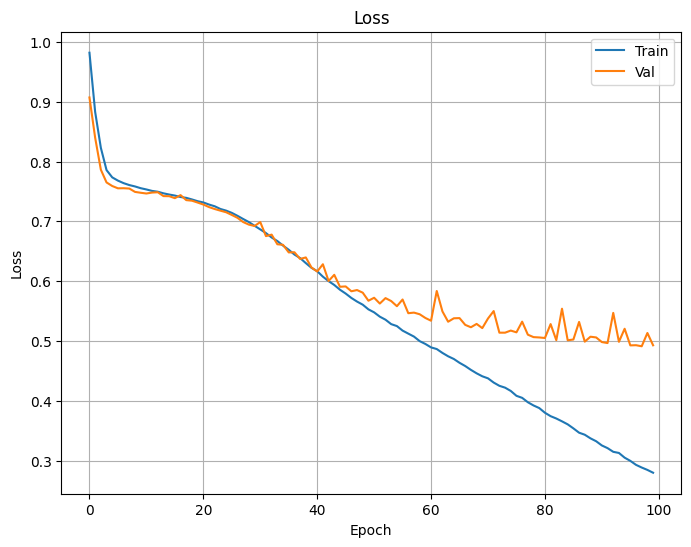

In [145]:
result = history_nn.history
n_epochs = np.arange(0, len(result['accuracy']))

plt.figure(figsize=(8,6))
plt.title("Loss")
plt.plot(n_epochs, result['loss'], label='Train')
plt.plot(n_epochs, result['val_loss'], label='Val')
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [146]:
# Save NN model
model_nn.save('/content/drive/MyDrive/Platinum Challenge/Neural Network.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [147]:
# Predict pakai data test atau data eval
y_pred_test_nn = model_nn.predict(X_test)

69/69 [==============================] - 1s 6ms/step


In [148]:
# Checking f1 score
matrix_test_nn = metrics.classification_report(y_test_hot.argmax(axis=1), y_pred_test_nn.argmax(axis=1))
print(matrix_test_nn)

              precision    recall  f1-score   support

           0       0.68      0.81      0.74       708
           1       0.75      0.23      0.36       213
           2       0.89      0.90      0.89      1279

    accuracy                           0.80      2200
   macro avg       0.77      0.65      0.66      2200
weighted avg       0.81      0.80      0.79      2200



## Define LSTM model

In [157]:
embed_dim = 128
lstm_out = 32
model_lstm = Sequential([
    Embedding(input_dim=input_dim, output_dim=embed_dim, input_length=X_train.shape[1]),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15, restore_best_weights=True)
#adam = tf.keras.optimizers.Adam(learning_rate=0.001)
sgd = tf.keras.optimizers.SGD(learning_rate=0.005)
model_lstm.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model_lstm.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 63, 128)           2159744   
                                                                 
 lstm_6 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_35 (Dense)            (None, 32)                2080      
                                                                 
 dense_36 (Dense)            (None, 3)                 99        
                                                                 
Total params: 2211331 (8.44 MB)
Trainable params: 2211331 (8.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [159]:
history_lstm = model_lstm.fit(X_train, y_train_hot, epochs=100, validation_data=(X_test, y_test_hot), batch_size=64, callbacks=[es])

Epoch 1/100
138/138 [==============================] - 18s 133ms/step - loss: 0.5517 - accuracy: 0.7703 - val_loss: 0.5550 - val_accuracy: 0.7768
Epoch 2/100
138/138 [==============================] - 19s 136ms/step - loss: 0.5485 - accuracy: 0.7715 - val_loss: 0.5598 - val_accuracy: 0.7727
Epoch 3/100
138/138 [==============================] - 16s 119ms/step - loss: 0.5476 - accuracy: 0.7710 - val_loss: 0.6107 - val_accuracy: 0.7568
Epoch 4/100
138/138 [==============================] - 17s 123ms/step - loss: 0.5438 - accuracy: 0.7731 - val_loss: 0.5528 - val_accuracy: 0.7782
Epoch 5/100
138/138 [==============================] - 19s 137ms/step - loss: 0.5406 - accuracy: 0.7717 - val_loss: 0.5547 - val_accuracy: 0.7727
Epoch 6/100
138/138 [==============================] - 23s 170ms/step - loss: 0.5368 - accuracy: 0.7738 - val_loss: 0.5410 - val_accuracy: 0.7827
Epoch 7/100
138/138 [==============================] - 16s 119ms/step - loss: 0.5335 - accuracy: 0.7766 - val_loss: 0.5426 -

Exception ignored in: <function _xla_gc_callback at 0x7a6c1b43eef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


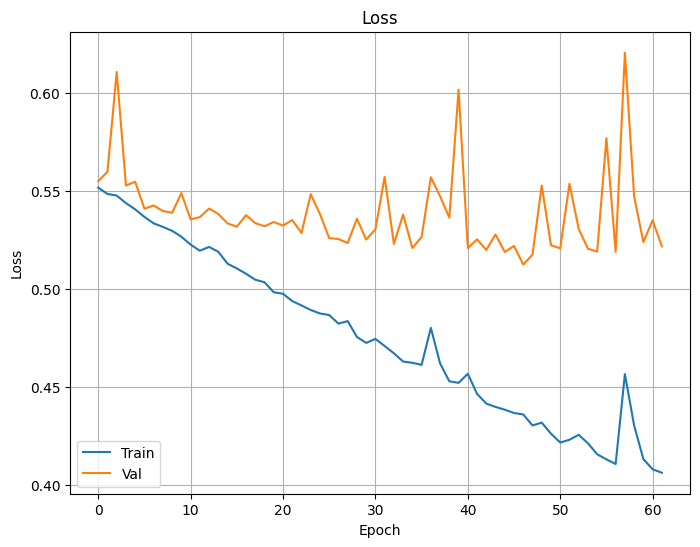

In [162]:
result = history_lstm.history
n_epochs = np.arange(0, len(result['accuracy']))

plt.figure(figsize=(8,6))
plt.title("Loss")
plt.plot(n_epochs, result['loss'], label='Train')
plt.plot(n_epochs, result['val_loss'], label='Val')
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [163]:
# Save LSTM model
model_lstm.save('/content/drive/MyDrive/Platinum Challenge/LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [164]:
# Predict pakai data test atau data eval
y_pred_test_lstm = model_lstm.predict(X_test)

69/69 [==============================] - 5s 28ms/step


In [165]:
# Checking f1 score
matrix_test_lstm = metrics.classification_report(y_test_hot.argmax(axis=1), y_pred_test_lstm.argmax(axis=1))
print(matrix_test_lstm)

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       708
           1       0.00      0.00      0.00       213
           2       0.90      0.90      0.90      1279

    accuracy                           0.79      2200
   macro avg       0.52      0.58      0.54      2200
weighted avg       0.73      0.79      0.76      2200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()